In [1]:
import params, os, funcs
from jaratoolbox import celldatabase, settings
import numpy as np

# %% Load dataframe
databaseDir = os.path.join(settings.DATABASE_PATH, '2024popanalysis')
fullDbPath = 'celldb_2024popanalysis.h5'
fullPath = os.path.join(databaseDir, fullDbPath)
fullDb = celldatabase.load_hdf(fullPath)
simpleSiteNames = fullDb["recordingSiteName"].str.split(',').apply(lambda x: x[0])
simpleSiteNames = simpleSiteNames.replace("Posterior auditory area", "Dorsal auditory area")
fullDb["recordingSiteName"] = simpleSiteNames
fullDb.head()

,behavSuffix,bestChannel,brainArea,cluster,cluster_label,date,egroup,ephysTime,info,maxDepth,...,pdepth,probe,recordingSiteName,recordingTrack,sessionType,spikeShape,subject,x_coord,y_coord,z_coord
0,"[a, b, a, b]",1,AC_right,1,good,2022-01-11,0,"[13-48-00, 13-55-58, 14-06-21, 14-20-08]","[facesMedial, soundLeft]",2318,...,2318,NPv1-2872,Primary auditory area,anteromedialDiD,"[AM, pureTones, VOT, FT]","[0.025128685, 0.020350156, 0.022057759, 0.0216...",feat004,397.032812,121.802719,201.0
1,"[a, b, a, b]",2,AC_right,7,good,2022-01-11,0,"[13-48-00, 13-55-58, 14-06-21, 14-20-08]","[facesMedial, soundLeft]",2318,...,2318,NPv1-2872,Primary auditory area,anteromedialDiD,"[AM, pureTones, VOT, FT]","[-0.0016647133, 0.01399436, 0.014463621, 0.017...",feat004,396.952150,121.215818,201.0
2,"[a, b, a, b]",5,AC_right,11,good,2022-01-11,0,"[13-48-00, 13-55-58, 14-06-21, 14-20-08]","[facesMedial, soundLeft]",2318,...,2318,NPv1-2872,Primary auditory area,anteromedialDiD,"[AM, pureTones, VOT, FT]","[0.011408528, 0.006604709, 0.0063931295, 0.003...",feat004,396.871488,120.628918,201.0
3,"[a, b, a, b]",5,AC_right,13,good,2022-01-11,0,"[13-48-00, 13-55-58, 14-06-21, 14-20-08]","[facesMedial, soundLeft]",2318,...,2318,NPv1-2872,Primary auditory area,anteromedialDiD,"[AM, pureTones, VOT, FT]","[0.008579502, 0.0046604094, 0.0045404034, 0.00...",feat004,396.871488,120.628918,201.0
4,"[a, b, a, b]",5,AC_right,14,good,2022-01-11,0,"[13-48-00, 13-55-58, 14-06-21, 14-20-08]","[facesMedial, soundLeft]",2318,...,2318,NPv1-2872,Primary auditory area,anteromedialDiD,"[AM, pureTones, VOT, FT]","[0.000733526, 0.028997183, 0.024717774, 0.0263...",feat004,396.871488,120.628918,201.0


In [2]:
X_speech_all, Y_brain_area_speech_all, X_AM_all = [], [], []
Y_brain_area_AM_all, X_pureTones_all, Y_brain_area_PT_all = [], [], []
previous_frequency_speech, previous_frequency_AM, previous_frequency_PT = None, None, None
indices_AM, indices_PT, indices_speech = None, None, None

In [3]:
# Add data to the dictionary for each brain area and sound type
for subject in params.subject_list:
    for date in params.recordingDate_list[subject]:
        for brain_area in params.targetSiteNames:
            speechEnsemble, speechEphys, speechBdata = funcs.load_data(subject, date, brain_area, "FTVOTBorders")

            if speechEnsemble:
                X_speech, Y_brain_area_speech, Y_frequency_speech = funcs.spike_rate("speech", speechEnsemble,
                                                                    speechEphys, speechBdata, brain_area)

                X_speech_array, Y_frequency_speech_sorted, previous_frequency_speech, indices_speech = (
                    funcs.adjust_speech_length(subject, date, brain_area, X_speech, Y_frequency_speech,
                                               Y_brain_area_speech, previous_frequency_speech))

                if X_speech_array is not None:
                    Y_frequency_FT = Y_frequency_speech_sorted[:, 0]
                    Y_frequency_VOT = Y_frequency_speech_sorted[:, 1]

                    # Append the data to the lists
                    X_speech_all.extend(X_speech_array)
                    Y_frequency_speech_2 = Y_frequency_speech_sorted
                    Y_brain_area_speech_all.extend(Y_brain_area_speech)

            # Load and process data for AM
            amEnsemble, amEphys, amBdata = funcs.load_data(subject, date, brain_area, "AM")
            if amEnsemble:
                X_AM, Y_brain_area_AM, Y_frequency_AM = funcs.spike_rate(
                    "AM", amEnsemble, amEphys, amBdata, brain_area)

                # Apply adjustments
                X_AM_adjusted, Y_frequency_AM_adjusted, Yba_AM_adj = (
                    funcs.adjust_array_and_labels(X_AM, Y_frequency_AM, Y_brain_area_AM, 
                                                  params.max_trials['AM'], subject, date, brain_area))

                # Sort arrays
                X_AM_array, Y_frequency_AM_sorted, Y_brain_area_AM_sorted, previous_frequency_AM, indices_AM = (
                    funcs.sort_sound_array(subject, date, brain_area, X_AM_adjusted, Yba_AM_adj, Y_frequency_AM_adjusted, previous_frequency_AM))

                if X_AM_array is not None:
                    # Append the data to the lists
                    X_AM_all.extend(X_AM_array)
                    Y_frequency_AM_2 = Y_frequency_AM_sorted
                    Y_brain_area_AM_all.extend(Y_brain_area_AM_sorted)

            # Load and process data for Pure Tones
            ptEnsemble, ptEphys, ptBdata = funcs.load_data(subject, date, brain_area, "pureTones")
            if ptEnsemble:
                X_pureTones, Y_brain_area_PT, Y_frequency_pureTones = funcs.spike_rate(
                    "PT", ptEnsemble, ptEphys, ptBdata, brain_area)

                # Apply adjustments
                X_PT_adjusted, Y_frequency_PT_adjusted, Yba_PT_adj = (
                    funcs.adjust_array_and_labels(X_pureTones, Y_frequency_pureTones, Y_brain_area_PT,
                                                  params.max_trials['PT'], subject, date, brain_area))

                # Sort arrays
                X_PT_array, Y_frequency_PT_sorted, Y_brain_area_PT_sorted, previous_frequency_PT, indices_PT = (
                    funcs.sort_sound_array(subject, date, brain_area, X_PT_adjusted, Yba_PT_adj, Y_frequency_PT_adjusted, previous_frequency_PT))

                if X_PT_array is not None:
                    # Append the data to the lists
                    X_pureTones_all.extend(X_PT_array)
                    Y_frequency_PT_2 = Y_frequency_PT_sorted
                    Y_brain_area_PT_all.extend(Y_brain_area_PT_sorted)

No FTVOTBorder data for Primary auditory area on 2022-01-11 for feat004
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Primary auditory area.
No FTVOTBorder data for Dorsal auditory area on 2022-01-11 for feat004
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Dorsal auditory area.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No FTVOTBorder data for Primary auditory area on 2022-01-19 for feat004
No FTVOTBorder data for Dorsal auditory area on 2022-01-19 for feat004
No data in Ventral auditory area on 2022-01-19 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-19 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-19 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-21 for Speech, AM, and PT.
No data in Ven

In [4]:
# %% Sort arrays
X_PT_sorted = funcs.sort_x_arrays(X_pureTones_all, indices_PT, "pt")
X_AM_sorted = funcs.sort_x_arrays(X_AM_all, indices_AM, "am")
X_speech_sorted = funcs.sort_x_arrays(X_speech_all, indices_speech, "speech")

# Convert the lists to numpy arrays for easy manipulation
X_speech_array = np.stack(X_speech_sorted, axis=0)
# X_speech_array = X_speech_array.squeeze(axis=1)
X_AM_array = np.stack(X_AM_sorted, axis=0)
X_PT_array = np.stack(X_PT_sorted, axis=0)

In [5]:
# Initialize a dictionary to store 2D arrays for each brain_area - sound_type combo
data_dict = {}

for brain_area in params.targetSiteNames:
    for sound_type, X_array, Y_brain_area_all, Y_frequency_sorted in zip(
            ['AM', 'PT', 'speech'],
            [X_AM_array, X_PT_array, X_speech_array],
            [Y_brain_area_AM_all, Y_brain_area_PT_all, Y_brain_area_speech_all],
            [Y_frequency_AM_2, Y_frequency_PT_2, Y_frequency_speech_2]):

        # Filter data based on the brain_area
        brain_area_array = np.array(Y_brain_area_all)
        X_array_adjusted = X_array[brain_area_array == brain_area]  # X is neurons x trials

        # Store the 2D array (neurons x trials) in the dictionary
        data_dict[(brain_area, sound_type)] = {
            'X': X_array_adjusted.T,  # Transpose to get the correct shape (neurons x trials)
            'Y': np.array(Y_frequency_sorted)}  # Y is a 1D array of frequencies

# Below is Firing Rate Analysis

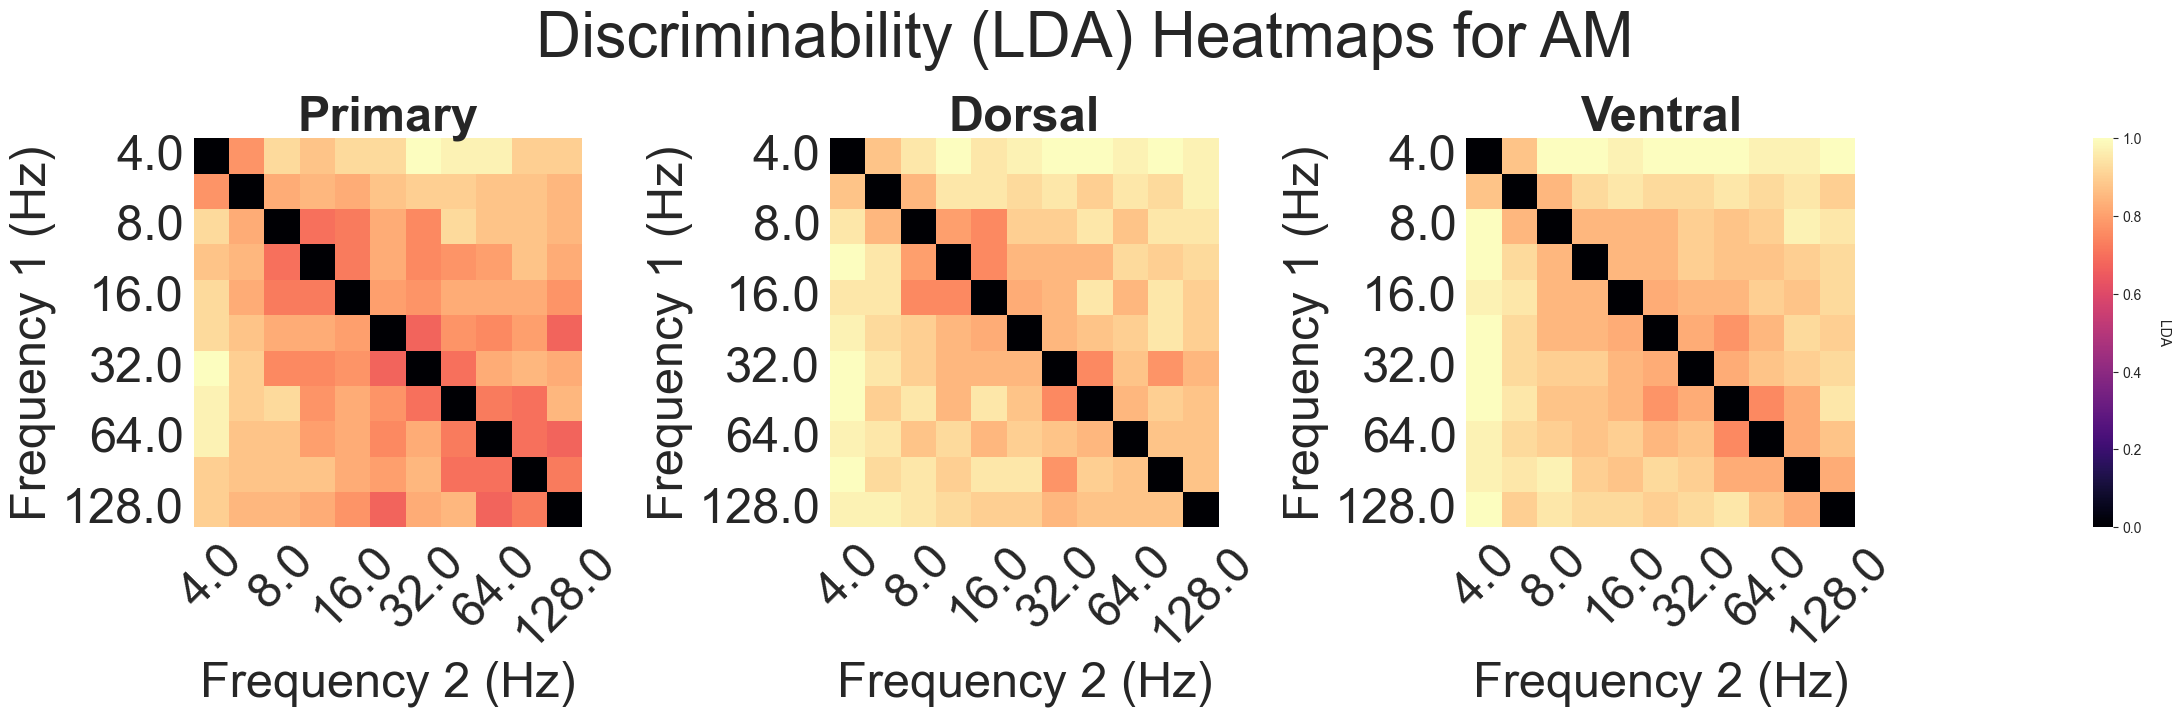

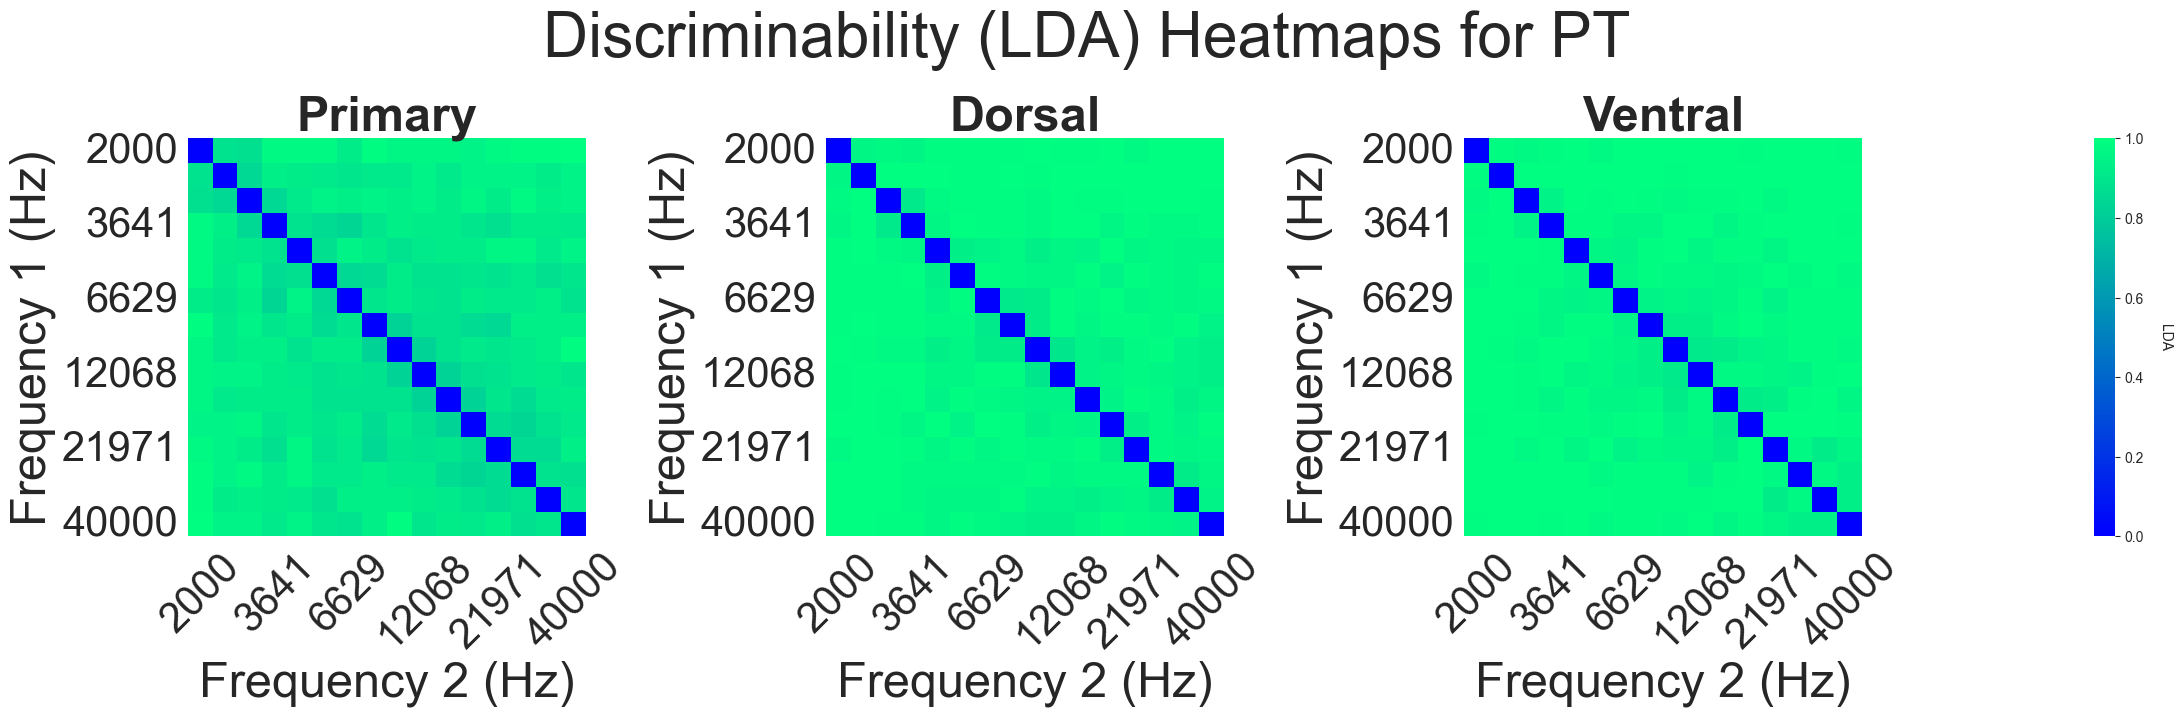

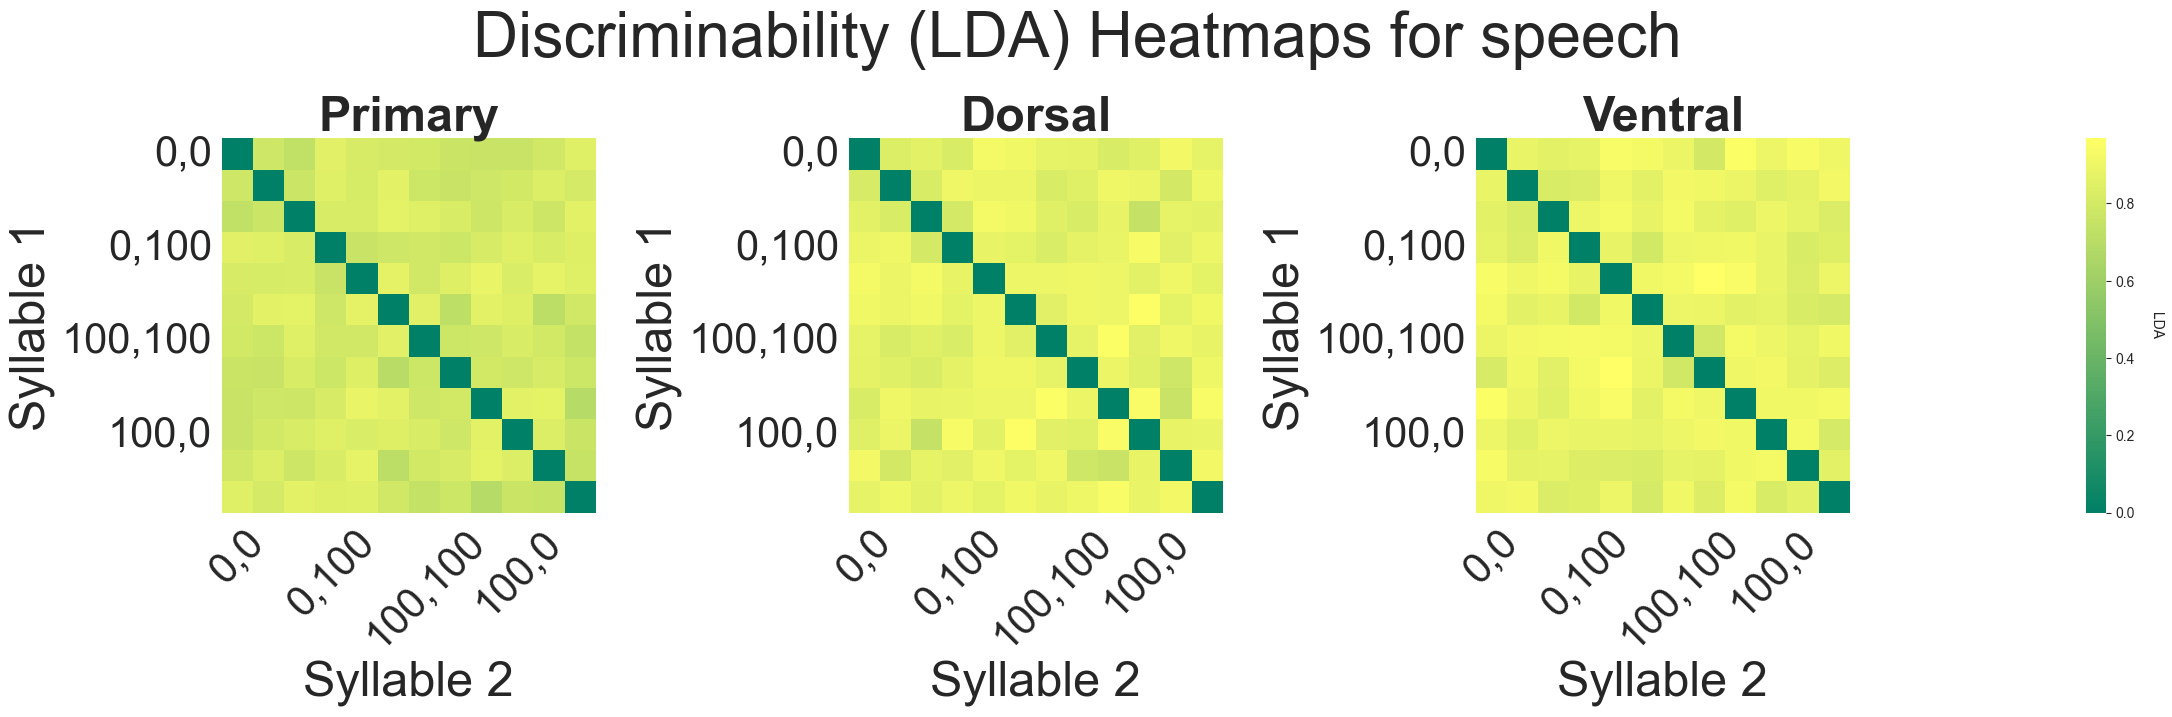

In [16]:
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

save_path = "/Users/zoetomlinson/Desktop/GitHub/neuronalDataResearch/Figures/Population Plots"
lda = LinearDiscriminantAnalysis()
lda_dict = {}

# Define color map per sound type
sound_colormaps = {
    'AM': cm.magma,
    'PT': cm.winter,
    'speech': cm.summer
}

short_names = {
    'Primary auditory area': 'Primary',
    'Dorsal auditory area':  'Dorsal',
    'Ventral auditory area': 'Ventral'
}

# Define all unique speech labels (VOT, FT)
unique_labels = [(0, 0), (0, 33), (0, 67), (0, 100), (33, 100), (67, 100),
                 (100, 100), (100, 67), (100, 33), (100, 0), (67, 0), (33, 0)]

for sound_type in ['AM', 'PT', 'speech']:
    lda_arrays_for_sound = []

    for brain_area in params.targetSiteNames:
        X_array = data_dict[(brain_area, sound_type)]['X']
        Y_array = data_dict[(brain_area, sound_type)]['Y']
        
        if sound_type == 'speech':
            vot_values = Y_array[:, 0]
            ft_values = Y_array[:, 1]
            unique_freqs = unique_labels
        else:
            unique_freqs = sorted(set(Y_array))
        
        lda_array = np.zeros((len(unique_freqs), len(unique_freqs)))
        
        for i, freq1 in enumerate(unique_freqs):
            for j, freq2 in enumerate(unique_freqs):
                if i == j:
                    continue
        
                if sound_type == 'speech':
                    mask_freq1 = (vot_values == freq1[0]) & (ft_values == freq1[1])
                    mask_freq2 = (vot_values == freq2[0]) & (ft_values == freq2[1])
                else:
                    mask_freq1 = Y_array == freq1
                    mask_freq2 = Y_array == freq2
        
                trials_freq1 = X_array[mask_freq1]
                trials_freq2 = X_array[mask_freq2]
        
                if len(trials_freq1) < 2 or len(trials_freq2) < 2:
                    lda_array[i, j] = np.nan
                    continue
        
                X_pair = np.vstack([trials_freq1, trials_freq2])
                y_pair = np.array([0]*len(trials_freq1) + [1]*len(trials_freq2))
        
                try:
                    lda.fit(X_pair, y_pair)
                    accuracy = lda.score(X_pair, y_pair)  # Resubstitution accuracy
                except Exception:
                    accuracy = np.nan
        
                lda_array[i, j] = accuracy
                
        lda_dict[(brain_area, sound_type)] = lda_array
        lda_arrays_for_sound.append(lda_array)

    # Global color scale bounds
    all_vals = np.concatenate([arr.flatten() for arr in lda_arrays_for_sound])
    global_min, global_max = np.min(all_vals), np.max(all_vals)

    # Setup for shared colorbar using GridSpec
    fig = plt.figure(figsize=(22, 7))
    fig.suptitle(f"Discriminability (LDA) Heatmaps for {sound_type}", fontsize=45)
    gs = gridspec.GridSpec(1, len(params.targetSiteNames) + 1, width_ratios=[1]*len(params.targetSiteNames) + [0.05])
    axs = [fig.add_subplot(gs[i]) for i in range(len(params.targetSiteNames))]
    cbar_ax = fig.add_subplot(gs[-1])  # Axis for shared colorbar

    # Plot
    for idx, brain_area in enumerate(params.targetSiteNames):
        lda_array = lda_dict[(brain_area, sound_type)]

        if sound_type == 'speech':
            all_labels = [f"{vot},{ft}" for vot, ft in unique_labels]
            label_mask = np.arange(len(all_labels)) % 3 == 0  # Show every other
        elif sound_type == 'PT':
            all_freqs = sorted(set(Y_array))
            all_labels = [str(int(round(val))) for val in all_freqs]  # Round to whole numbers
            label_mask = np.arange(len(all_labels)) % 3 == 0  # Show every 5th
        else:  # AM
            all_freqs = sorted(set(Y_array))
            all_labels = [str(val) for val in all_freqs]
            label_mask = np.arange(len(all_labels)) % 2 == 0  # Show every other
        
        x_labels = [label if show else "" for label, show in zip(all_labels, label_mask)]
        y_labels = [label if show else "" for label, show in zip(all_labels, label_mask)]
        sns.heatmap(lda_array, cmap=sound_colormaps[sound_type],
                    xticklabels=x_labels, yticklabels=y_labels,
                    vmin=global_min, vmax=global_max,
                    ax=axs[idx], cbar=(idx == 0), cbar_ax=cbar_ax if idx == 0 else None)
            
        # Axis labels and tick size
        if sound_type == "speech":
            axs[idx].set_xlabel("Syllable 2", size=35)
            axs[idx].set_ylabel("Syllable 1", size=35)
            axs[idx].tick_params(axis='x', labelsize=30, rotation=45)
            axs[idx].tick_params(axis='y', labelsize=30, rotation=0)
        elif sound_type == "PT":
            axs[idx].set_xlabel("Frequency 2 (Hz)", size=35)
            axs[idx].set_ylabel("Frequency 1 (Hz)", size=35)
            axs[idx].tick_params(axis='x', labelsize=30, rotation=45)
            axs[idx].tick_params(axis='y', labelsize=30, rotation=0)
        else:
            axs[idx].set_xlabel("Frequency 2 (Hz)", size=35)
            axs[idx].set_ylabel("Frequency 1 (Hz)", size=35)
            axs[idx].tick_params(axis='x', labelsize=35, rotation=45)
            axs[idx].tick_params(axis='y', labelsize=35, rotation=0)

        axs[idx].set_title(f"{brain_area}", fontsize=40, fontweight="bold", y=1.1)
        axs[idx].set_aspect("equal")
        axs[idx].set_title(short_names.get(brain_area, brain_area), fontsize=35, fontweight="bold")

    cbar_ax.set_ylabel('LDA', rotation=270, labelpad=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95], w_pad=0.5, h_pad=1.0)
    filename = f"{sound_type}_all_brain_areas_lda_heatmap.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, bbox_inches='tight')

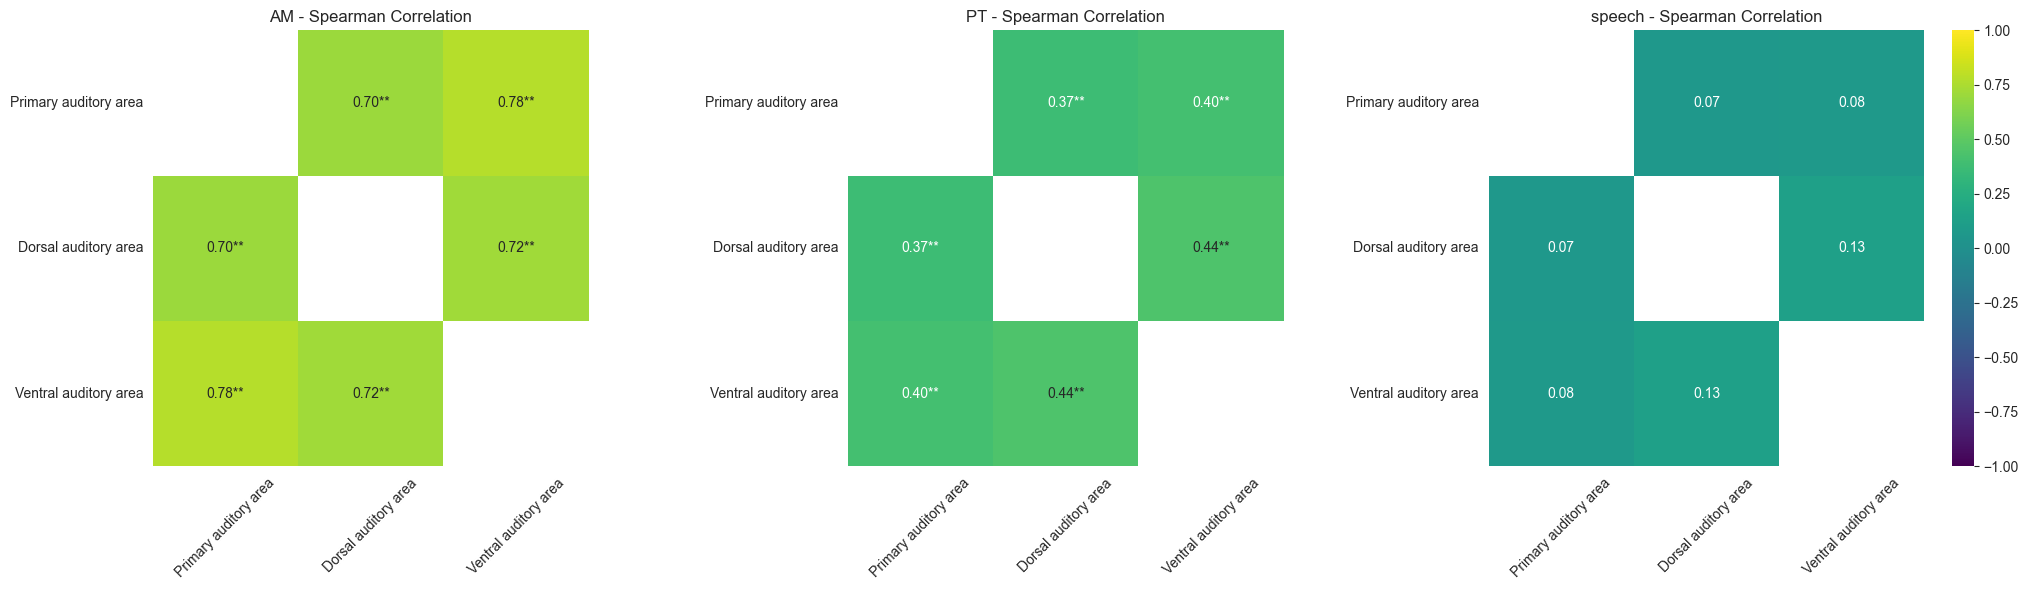

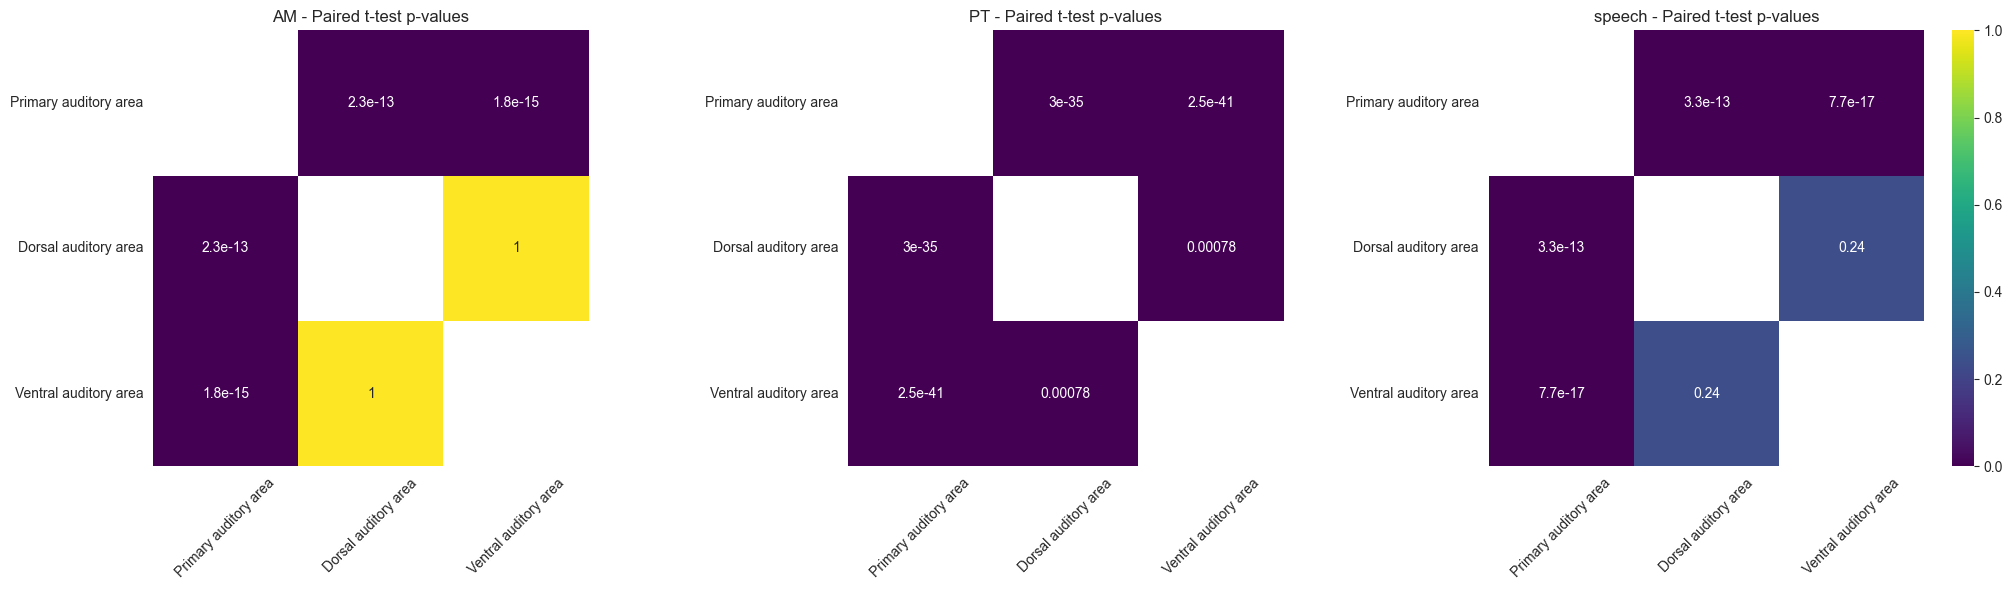

In [17]:
import pandas as pd
from scipy.stats import spearmanr, ttest_rel
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

fig_corr, axs_corr = plt.subplots(1, 3, figsize=(21, 6))
fig_pval, axs_pval = plt.subplots(1, 3, figsize=(21, 6))
significant_pairs = []

sound_types = ['AM', 'PT', 'speech']
areas = params.targetSiteNames  # Assuming this is a list of area names

for idx, sound_type in enumerate(sound_types):
    n_areas = len(areas)

    # Initialize correlation and p-value matrices
    corr_matrix = pd.DataFrame(np.nan, index=areas, columns=areas)
    pval_matrix = pd.DataFrame(np.nan, index=areas, columns=areas)
    annot_matrix = pd.DataFrame('', index=areas, columns=areas)

    combos = list(itertools.combinations(areas, 2))
    for brain1, brain2 in combos:
        matrix1 = lda_dict.get((brain1, sound_type))
        matrix2 = lda_dict.get((brain2, sound_type))

        if matrix1 is None or matrix2 is None or matrix1.shape != matrix2.shape:
            print(f"Skipping {brain1} vs {brain2} for {sound_type} due to shape mismatch.")
            continue

        # Take only the upper triangle, excluding diagonal
        mask = np.triu(np.ones(matrix1.shape), k=1).astype(bool)
        flat1 = matrix1[mask]
        flat2 = matrix2[mask]

        # Spearman and paired t-test
        rho, spearman_p = spearmanr(flat1, flat2)
        t_stat, ttest_p = ttest_rel(flat1, flat2)
        
        if ttest_p < 0.05:
            significant_pairs.append((sound_type, brain1, brain2))

        # Fill matrices symmetrically
        corr_matrix.loc[brain1, brain2] = corr_matrix.loc[brain2, brain1] = rho
        pval_matrix.loc[brain1, brain2] = pval_matrix.loc[brain2, brain1] = ttest_p

        # Annotate Spearman with stars
        stars = '**' if spearman_p < 0.01 else '*' if spearman_p < 0.05 else ''
        text = f"{rho:.2f}{stars}"
        annot_matrix.loc[brain1, brain2] = annot_matrix.loc[brain2, brain1] = text

    # Plot Spearman
    sns.heatmap(
        corr_matrix.astype(float),
        annot=annot_matrix.values,
        fmt='',
        cmap='viridis',
        vmin=-1,
        vmax=1,
        square=True,
        ax=axs_corr[idx],
        cbar=(idx == len(sound_types) - 1)
    )

    axs_corr[idx].set_title(f"{sound_type} - Spearman Correlation")
    axs_corr[idx].tick_params(axis='x', rotation=45)
    axs_corr[idx].tick_params(axis='y', rotation=0)

    # Plot Paired t-test p-values
    sns.heatmap(
        pval_matrix.astype(float),
        annot=True,
        cmap='viridis',
        vmin=0,
        vmax=1,
        square=True,
        ax=axs_pval[idx],
        cbar=(idx == len(sound_types) - 1)
    )

    # White-out diagonal
    for i in range(n_areas):
        axs_corr[idx].add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='white', lw=0))
        axs_pval[idx].add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='white', lw=0))

    axs_pval[idx].set_title(f"{sound_type} - Paired t-test p-values")
    axs_pval[idx].tick_params(axis='x', rotation=45)
    axs_pval[idx].tick_params(axis='y', rotation=0)

fig_corr.tight_layout()
fig_pval.tight_layout()

fig_corr.savefig(os.path.join(save_path, "all_soundtypes_LDA_spearman_heatmaps.png"))
fig_pval.savefig(os.path.join(save_path, "all_soundtypes_LDA_ttest_pval_heatmaps.png"))

In [18]:
significant_pairs

[('AM', 'Primary auditory area', 'Dorsal auditory area'),
 ('AM', 'Primary auditory area', 'Ventral auditory area'),
 ('PT', 'Primary auditory area', 'Dorsal auditory area'),
 ('PT', 'Primary auditory area', 'Ventral auditory area'),
 ('PT', 'Dorsal auditory area', 'Ventral auditory area'),
 ('speech', 'Primary auditory area', 'Dorsal auditory area'),
 ('speech', 'Primary auditory area', 'Ventral auditory area')]

In [19]:
# Collect data for d-prime boxplot
lda_data = []

# Define custom color mapping
sound_order = ['PT', 'AM', 'speech']
sound_palette = {
    'PT': cm.winter(0.5),
    'AM': cm.magma(0.5),
    'speech': cm.summer(0.5)
}

for sound_type in sound_types:
    for area in areas:
        matrix = lda_dict.get((area, sound_type))

        if matrix is None:
            continue

        # Take only the upper triangle, excluding diagonal
        upper_triangle_mask = np.triu(np.ones(matrix.shape), k=1).astype(bool)
        flat_lda = matrix[upper_triangle_mask]

        for val in flat_lda:
            lda_data.append({
                'Brain Area': area,
                'Sound': sound_type,
                'LDA': val
            })

# Convert to DataFrame
lda_df = pd.DataFrame(lda_data)
lda_df

,Brain Area,Sound,LDA
0,Primary auditory area,AM,0.775000
1,Primary auditory area,AM,0.925000
2,Primary auditory area,AM,0.875000
3,Primary auditory area,AM,0.925000
4,Primary auditory area,AM,0.925000
...,...,...,...
718,Ventral auditory area,speech,0.909091
719,Ventral auditory area,speech,0.926471
720,Ventral auditory area,speech,0.924242
721,Ventral auditory area,speech,0.808824


In [20]:
from scipy.stats import f_oneway
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Store significant pairs for annotation
significant_pairs = []

# Perform one-way ANOVA + Tukey HSD per sound type
for sound_type in sound_order:
    # Extract d-prime values for each area
    group_data = [
        lda_df[(lda_df['Sound'] == sound_type) & (lda_df['Brain Area'] == area)]['LDA']
        for area in areas
    ]

    # Run one-way ANOVA
    f_stat, p_anova = f_oneway(*group_data)

    if p_anova < 0.05:
        # Run Tukey's HSD test for post-hoc pairwise comparisons
        subset_df = lda_df[lda_df['Sound'] == sound_type]
        tukey = pairwise_tukeyhsd(endog=subset_df['LDA'],
                                  groups=subset_df['Brain Area'],
                                  alpha=0.05)

        # Extract significant pairs from Tukey HSD results
        for result in tukey.summary().data[1:]:  # skip header row
            area1, area2, _, _, _, p_adj, reject = result
            if reject:
                significant_pairs.append((sound_type, area1, area2))
                
significant_pairs

[('PT', 'Dorsal auditory area', 'Primary auditory area'),
 ('PT', 'Primary auditory area', 'Ventral auditory area'),
 ('AM', 'Dorsal auditory area', 'Primary auditory area'),
 ('AM', 'Primary auditory area', 'Ventral auditory area'),
 ('speech', 'Dorsal auditory area', 'Primary auditory area'),
 ('speech', 'Primary auditory area', 'Ventral auditory area')]

/var/folders/l9/v78y7h896278tzntj74hkdkr0000gn/T/ipykernel_47938/2991733177.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sound_order, fontsize=25)


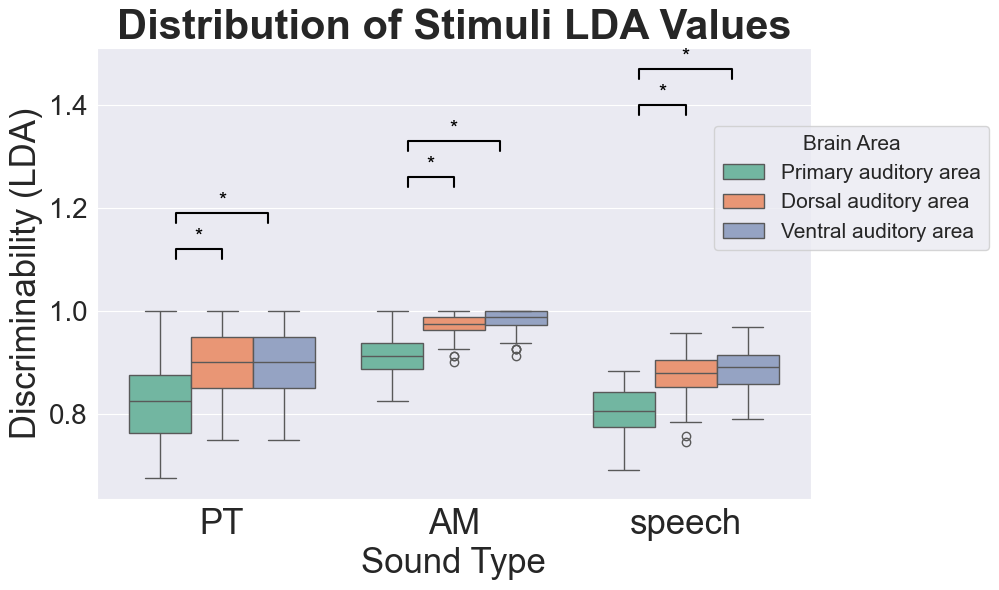

In [22]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=lda_df,
    x='Sound',
    y='LDA',
    hue='Brain Area',
    hue_order=areas,
    palette='Set2',
    ax=ax
)

plt.title('Distribution of Stimuli LDA Values', fontweight='bold', fontsize=30)

# Updated significance bar stacking logic
box_offsets = {area: i * 0.2 - 0.2 for i, area in enumerate(areas)}  # now offset per brain area

# Track top height for stacking
stack_base_y = lda_df['LDA'].max() + 0.1
stack_height = 0.07  # vertical spacing between stacked bars
stack_counter = 0

for sound, area1, area2 in significant_pairs:
    if area1 not in areas or area2 not in areas:
        continue

    x = sound_order.index(sound)  # now x is sound type
    x1 = x + box_offsets[area1]
    x2 = x + box_offsets[area2]

    y = stack_base_y + stack_counter * stack_height

    ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1.5, c='k')
    ax.text((x1 + x2) / 2, y + 0.025, '*', ha='center', va='bottom', color='k', fontsize=15)
    stack_counter += 1

# Set axis labels
ax.set_ylabel('Discriminability (LDA)', fontsize=25)
ax.set_xlabel("Sound Type", fontsize=25)

# Set tick label font sizes
ax.set_xticklabels(sound_order, fontsize=25)
ax.tick_params(axis='y', labelsize=20)

# Legend
legend = ax.legend(title='Brain Area', title_fontsize=15, fontsize=15, bbox_to_anchor=(0.85, 0.85))

plt.tight_layout()
plt.savefig(os.path.join(save_path, "boxplot_LDA_by_sound_and_area.png"))
plt.show()

In [12]:
for sound_type in sound_types:
    print(f"\n=== {sound_type.upper()} PAIRWISE COMPARISONS ===")
    combos = list(itertools.combinations(areas, 2))
    for brain1, brain2 in combos:
        matrix1 = lda_dict.get((brain1, sound_type))
        matrix2 = lda_dict.get((brain2, sound_type))

        if matrix1 is None or matrix2 is None or matrix1.shape != matrix2.shape:
            print(f"Skipping {brain1} vs {brain2} (shape mismatch)")
            continue

        # Remove diagonal
        mask = ~np.eye(matrix1.shape[0], dtype=bool)
        flat1 = matrix1[mask]
        flat2 = matrix2[mask]

        # Paired t-test
        t_stat, p_val = ttest_rel(flat1, flat2)
        mean_diff = np.mean(flat1 - flat2)

        if mean_diff > 0:
            winner = brain1
        elif mean_diff < 0:
            winner = brain2
        else:
            winner = "Equal"

        print(f"{brain1} vs {brain2} | Δd′ = {mean_diff:.3f}, p = {p_val:.4f} → {winner} has higher d′")


=== AM PAIRWISE COMPARISONS ===
Primary auditory area vs Dorsal auditory area | Δd′ = -0.080, p = 0.0000 → Dorsal auditory area has higher d′
Primary auditory area vs Ventral auditory area | Δd′ = -0.080, p = 0.0000 → Ventral auditory area has higher d′
Dorsal auditory area vs Ventral auditory area | Δd′ = -0.000, p = 1.0000 → Ventral auditory area has higher d′

=== PT PAIRWISE COMPARISONS ===
Primary auditory area vs Dorsal auditory area | Δd′ = -0.061, p = 0.0000 → Dorsal auditory area has higher d′
Primary auditory area vs Ventral auditory area | Δd′ = -0.068, p = 0.0000 → Ventral auditory area has higher d′
Dorsal auditory area vs Ventral auditory area | Δd′ = -0.007, p = 0.0000 → Ventral auditory area has higher d′

=== SPEECH PAIRWISE COMPARISONS ===
Primary auditory area vs Dorsal auditory area | Δd′ = -0.070, p = 0.0000 → Dorsal auditory area has higher d′
Primary auditory area vs Ventral auditory area | Δd′ = -0.079, p = 0.0000 → Ventral auditory area has higher d′
Dorsal au